In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data as udata
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Generation of 1D piecewise constant signals
class PieceWiseConstantDataset(udata.Dataset):

    def __init__(self, n_data = 1000, n_signal = 40, prob=0.3, fix_datapoints = True,
                  min_val = 0, max_val = 1, min_sep = 20, min_diff=0.4, use_circular_shift=True, circular_shift_get_item= False, seed=0, shift_item = False):
        super(PieceWiseConstantDataset, self).__init__()

        assert(min_sep > 0)
        self.n_data = n_data;
        self.n_signal = n_signal;
        self.prob = prob
        self.fix_datapoints = fix_datapoints;
        self.min_val = min_val;
        self.max_val = max_val;
        self.min_sep = min_sep;
        self.min_diff = min_diff
        assert min_diff < (max_val-min_val)/2

        self.use_circular_shift = use_circular_shift
        self.circular_shift_get_item = circular_shift_get_item
        self.shift_item =shift_item

        np.random.seed(seed)

        if self.fix_datapoints:
            self.data_list = [None] * self.n_data;
            for i in range(self.n_data):
                # self.data_list[i] = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
                self.data_list[i] = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

    def __len__(self):
        return self.n_data

    def circular_shift_shift(self, signal, shift):
        return np.roll(signal, shift)

    def circular_shift(self, signal, shift):
        if shift > int(self.n_signal/2):
          return np.flip(signal).copy()
        else:
          return signal


    def gen_piecewise_constant(self, n, prob, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        min_diff = self.min_diff
        signal = np.zeros(n)
        val = np.random.uniform(min_val, max_val);
        ind = np.random.randint(n)
        for i in range(n):
            signal[ind] = val
            if np.random.rand() < prob:

                new_val = np.random.uniform(min_val, max_val)
                # Ensure the new value differs from the old value by at least min_diff
                while abs(new_val - val) < min_diff:
                    new_val = np.random.uniform(min_val, max_val)
                val = new_val
                # val = np.random.uniform(min_val, max_val);
            ind = np.mod(ind + 1,n)
        return signal

    def gen_piecewise_constant_minsep(self, n, prob, minsep, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        signal = np.zeros(n)
        ind = 0
        val = np.random.uniform(min_val, max_val);
        while ind < n:
            if ind + minsep > n:
                signal[ind:] = val
                break
            if ind == 0 or np.random.rand() < prob:
                val = np.random.uniform(min_val, max_val);
                sep = np.random.randint(1, minsep+1) if ind == 0 else minsep;
                if ind + sep > n:
                    signal[ind:] = val
                    break
                else:
                    signal[ind:(ind+sep)] = val
                    ind += sep
            else:
                signal[ind] = val
                ind += 1
        if self.use_circular_shift:
          shift = np.random.randint(n)
          # print(signal)
          signal = self.circular_shift(signal, shift)
        return signal

    def __getitem__(self, index):

        if self.fix_datapoints:
            signal = self.data_list[index];
        else:
            # signal = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
            signal = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

        if self.circular_shift_get_item:
          shift = np.random.randint(self.n_signal)
          if not self.shift_item:
            signal = self.circular_shift(signal, shift)
          else:
            signal = self.circular_shift_shift(signal, shift)



        return torch.from_numpy(signal).unsqueeze(0).type(torch.FloatTensor)

In [3]:
# Generation of noise
def get_noise(signal, noise_std=0.1, noise_scale=1, max_noise=1,  mode='G'):
    if mode == 'poisson':
        scaled_signal = signal * noise_scale
        noise_sample = torch.tensor(np.random.poisson(scaled_signal.numpy()))
        noise = (noise_sample - scaled_signal) / noise_scale
    else:
        noise = torch.normal(0, noise_std, size=signal.shape)

    noise = torch.clamp(noise, -max_noise, max_noise)
    return noise


In [14]:
# Evaluation of denoising error
def evaluate_error(model, dataset_val, noise_std):
    model.eval()
    error_val = 0;
    total_length = 0;

    criterion = nn.MSELoss(reduction='mean');

    for data in dataset_val:
        out_val = model(data + get_noise(data, noise_std) );
        error_val += criterion(out_val, data).item()
        total_length += 1;

    return error_val/total_length

In [15]:
# Training of the denoising neural network with continuous noise sampling
def train_network(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );

            loss = criterion(out_train, data);
            loss.backward()
            optimizer.step()
            loss_all += loss.item()

        train_loss[epoch] = evaluate_error(model, train_loader, noise_std)
        val_loss[epoch] =  evaluate_error(model, val_loader, noise_std)

        if epoch % 10 == 0:
            print(epoch, 'train error: ', train_loss[epoch],'validation error: ',val_loss[epoch])

    return train_loss, val_loss

In [16]:
# 1D denoising convolutional neural network
class CNN(nn.Module):
	def __init__(self, depth=20, n_channels=16, image_channels=1, use_bnorm=True, kernel_size=3, use_bias=True):
		super(CNN, self).__init__()
		kernel_size = 3
		padding = 1

		self.use_bnorm = use_bnorm;
		self.depth = depth;
		self.use_bias = use_bias

		self.first_layer = nn.Conv1d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self.hidden_layer_list = [None] * (self.depth - 2);
		if self.use_bnorm:
			self.bn_layer_list = [None] * (self.depth -2 );

		for i in range(self.depth-2):
			self.hidden_layer_list[i] = nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias);
			if self.use_bnorm:
				self.bn_layer_list[i] = nn.BatchNorm1d(n_channels, eps=0.0001, momentum = 0.95)

		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
		if self.use_bnorm:
			self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
		self.last_layer = nn.Conv1d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self._initialize_weights()

	def forward(self, x):

		out = self.first_layer(x);
		out = F.relu(out);

		for i in range(self.depth-2):
			out = self.hidden_layer_list[i](out);
			if self.use_bnorm:
				out = self.bn_layer_list[i](out);
			out = F.relu(out)

		out = self.last_layer(out);

		return out

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				init.orthogonal_(m.weight)
				# print('init weight')
				if m.bias is not None:
					init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm1d):
				init.constant_(m.weight, 1)
				init.constant_(m.bias, 0)

In [17]:
# Generation of training and validation dataset
signal_length = 100
train_dataset = PieceWiseConstantDataset(n_data = 500, prob = 0.3, n_signal = signal_length, fix_datapoints = True, min_sep = 5, use_circular_shift=False, circular_shift_get_item=True);
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = 0.3, min_sep = 5, use_circular_shift=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [18]:
# Visualization of results
def visualize_denoising(source, net, noise_std, figsize=(10,10)):
    noise_sample = get_noise(source, noise_std);
    reconstructed = net(source+noise_sample);

    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=figsize);
    axes[0].plot(source.data.numpy().reshape(-1))
    axes[0].set_title('Signal')

    axes[1].plot(noise_sample.data.numpy().reshape(-1))
    axes[1].set_title('Noise Sample')

    axes[2].plot((source+noise_sample).data.numpy().reshape(-1))
    axes[2].set_title('Noisy data')

    axes[3].plot(reconstructed.data.numpy().reshape(-1))
    axes[3].set_title('Reconstructed')

    plt.show()
def visualize_coeffs_and_denoising(source, net, noise_std, figsize=(10,20)):
    noise_sample = get_noise(source, noise_std)
def visualize_filter(net):
    n = net.num_filters;

    fig, axes = plt.subplots(n, 2, sharex=True, sharey=True, figsize=(10, 5));
#     plt.setp(axes.flat,  adjustable='box-forced');

    if n==1:
        axes[0].stem(net.get_forward_filter_list()[0])
        axes[1].stem(net.get_inverse_filter_list()[0])
    else:
        for i in range(n):
            axes[i][0].stem(net.get_forward_filter_list()[i])
            axes[i][1].stem(net.get_inverse_filter_list()[i])

    plt.show()

In [19]:
# Specification of network architecture
net_nn = CNN(depth=2, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)

In [20]:
net_nn

CNN(
  (first_layer): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (hidden_layer_list): ModuleList()
  (last_layer): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)

In [21]:
# Training
noise_scale = noise_std = 0.1
train_loss_cnn, val_loss_cnn = train_network(net_nn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)

0 train error:  0.028345482307486236 validation error:  0.028238564366474747
10 train error:  0.004666460328735411 validation error:  0.004729526438750326
20 train error:  0.004085581036633812 validation error:  0.004123520143330097
30 train error:  0.003858526615658775 validation error:  0.00375261276261881
40 train error:  0.003685938791022636 validation error:  0.0035893635754473507
50 train error:  0.0034703879355220124 validation error:  0.003628966910764575
60 train error:  0.003514380005071871 validation error:  0.0034778094897046684
70 train error:  0.0035687432682607323 validation error:  0.0036056231299880894
80 train error:  0.0035616497916635126 validation error:  0.0035543039231561123
90 train error:  0.003607855935115367 validation error:  0.003571152918739244


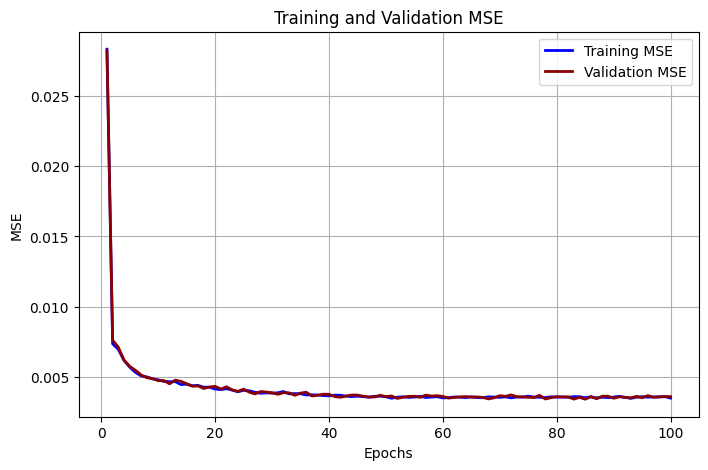

In [24]:
epochs = range(1, len(train_loss_cnn) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss_cnn, color='blue', label='Training MSE', linewidth=2)
plt.plot(epochs, val_loss_cnn, color='darkred', label='Validation MSE', linewidth=2)

plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training and Validation MSE")
plt.legend()
plt.grid(True)

plt.show()

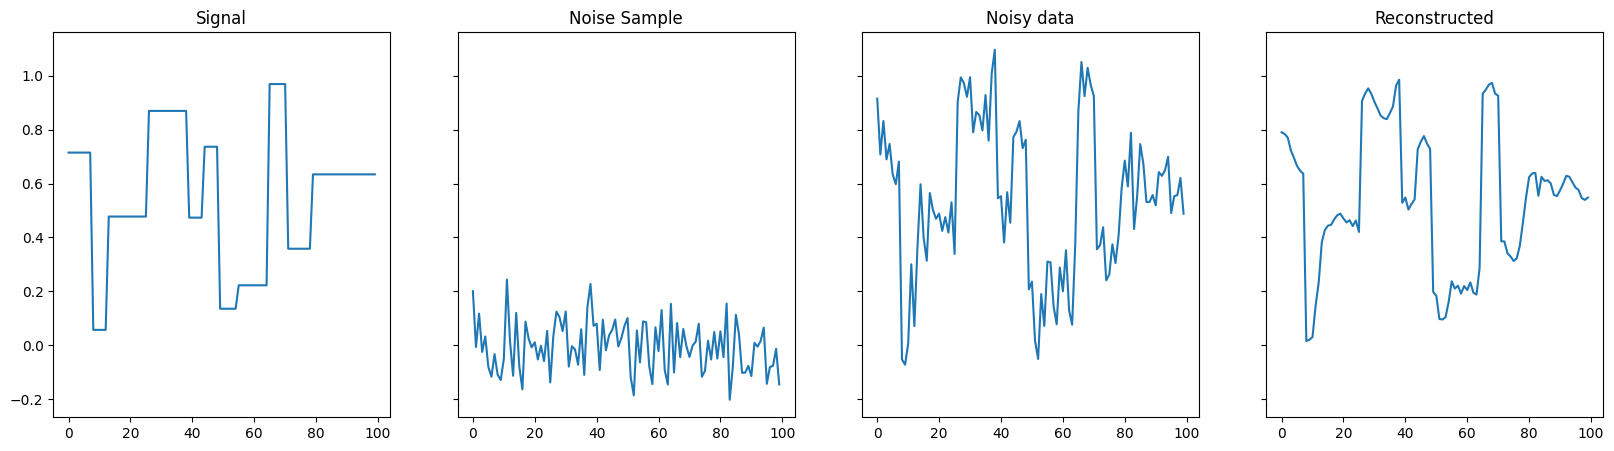

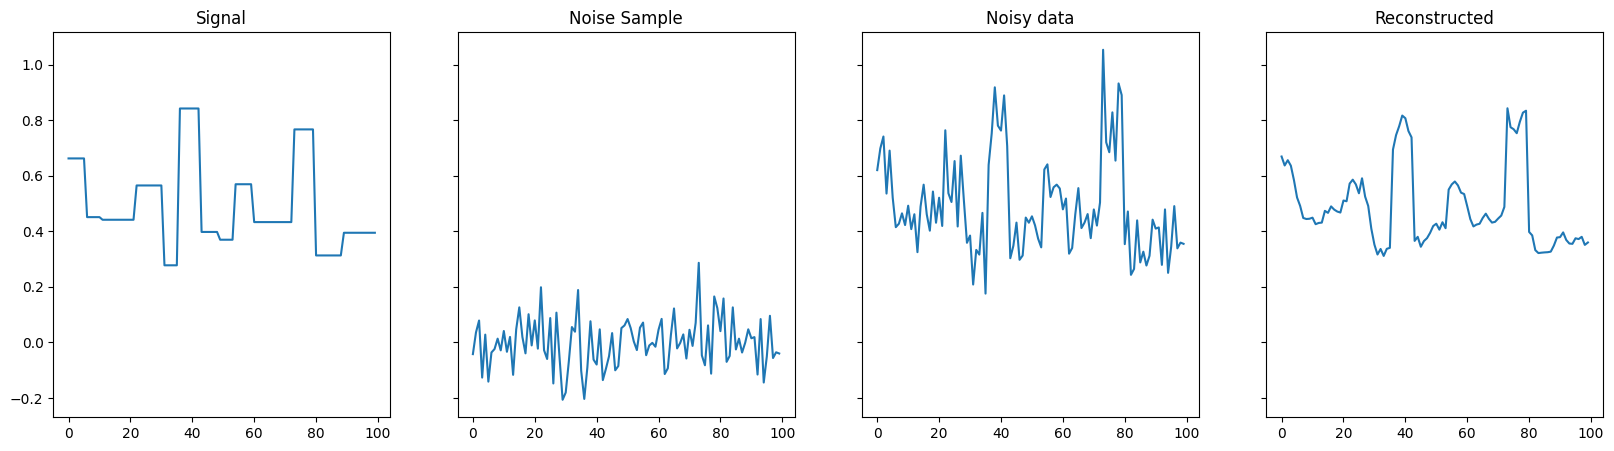

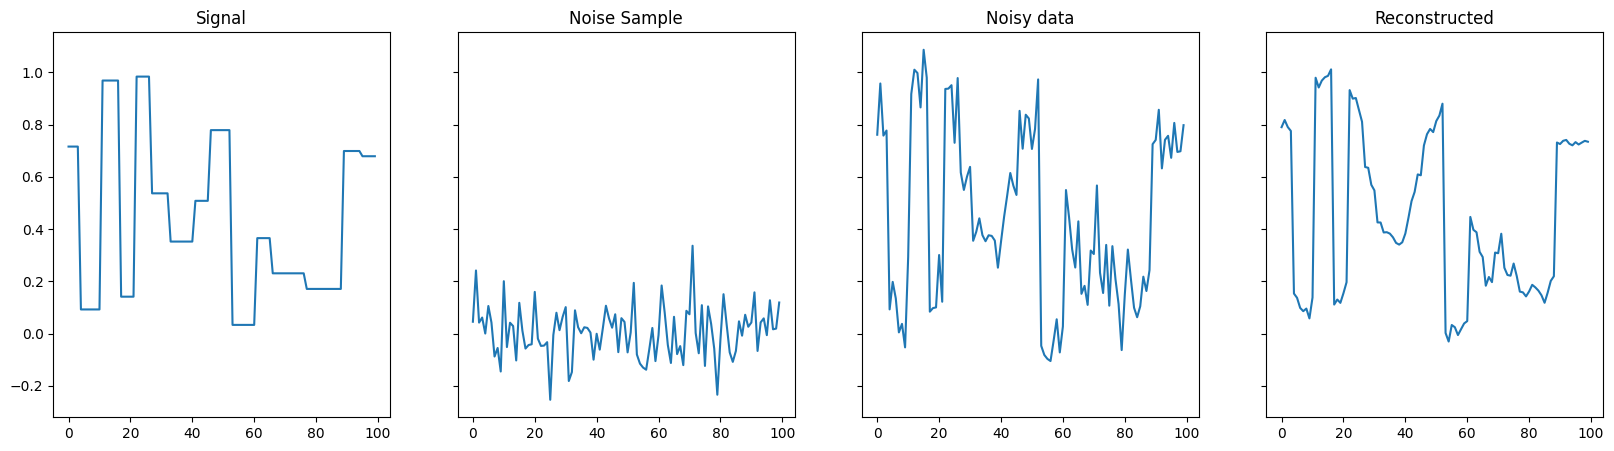

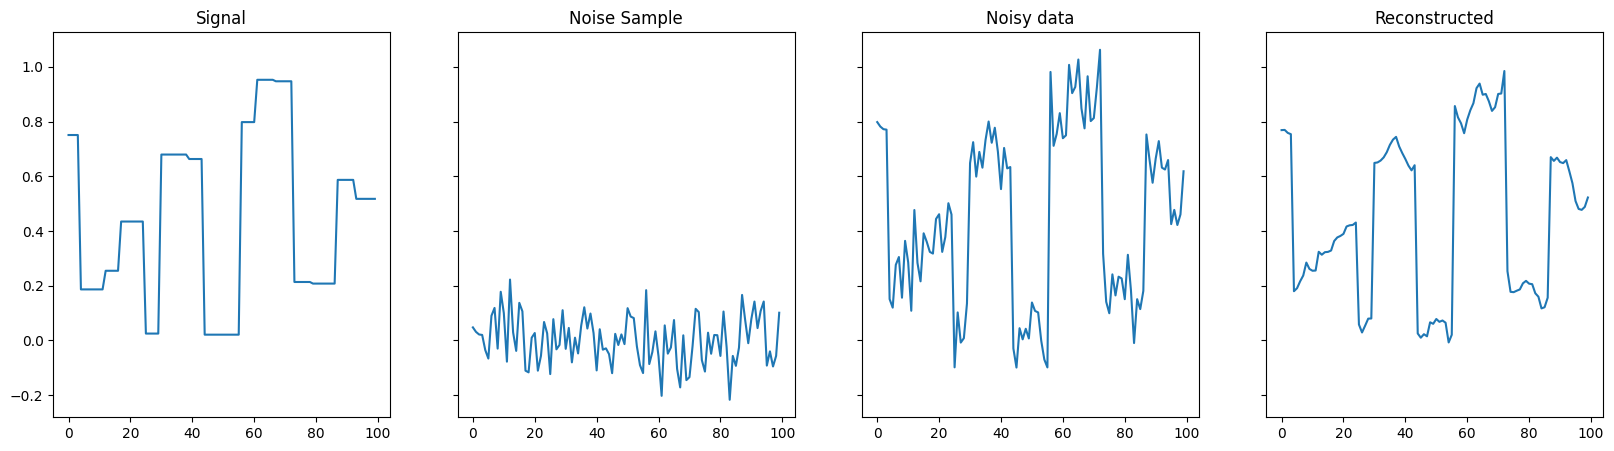

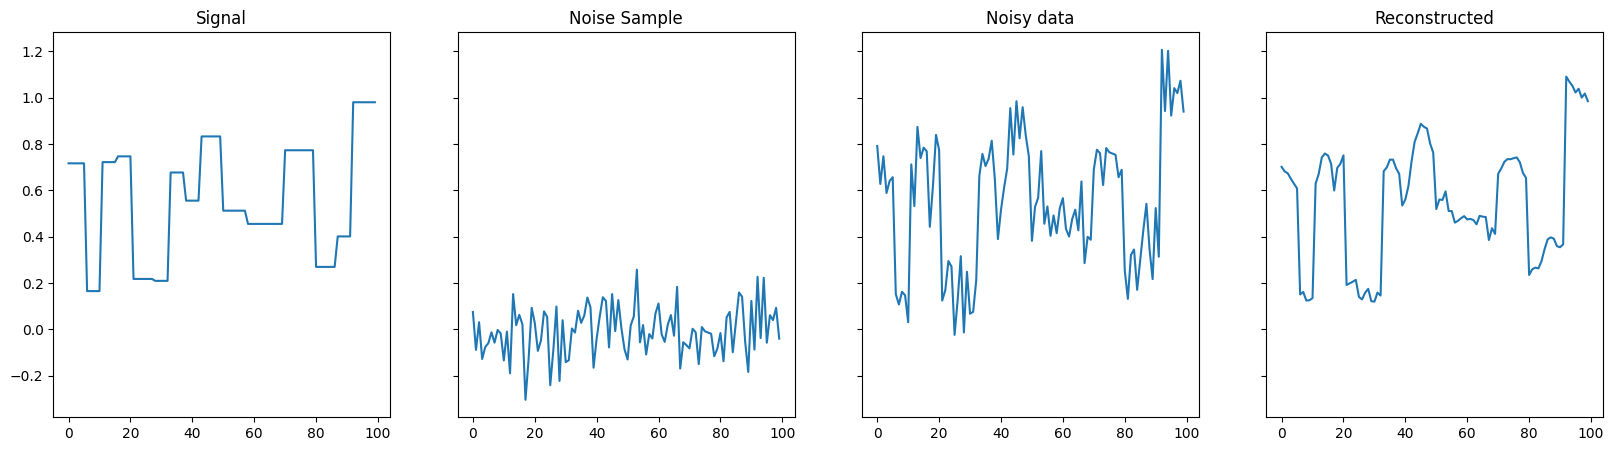

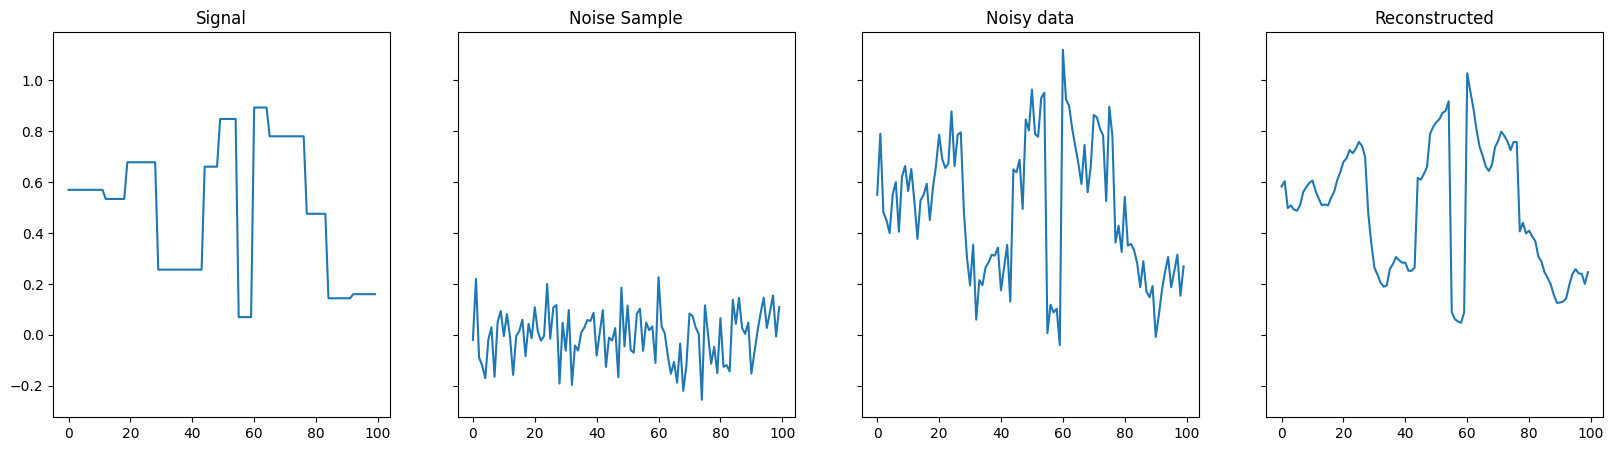

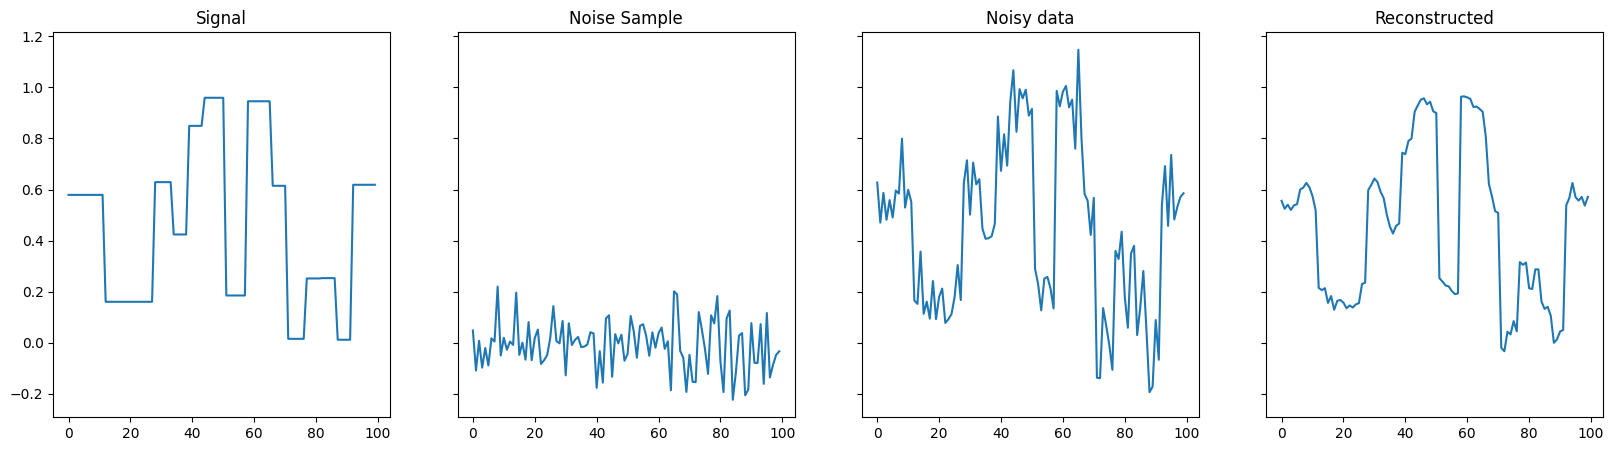

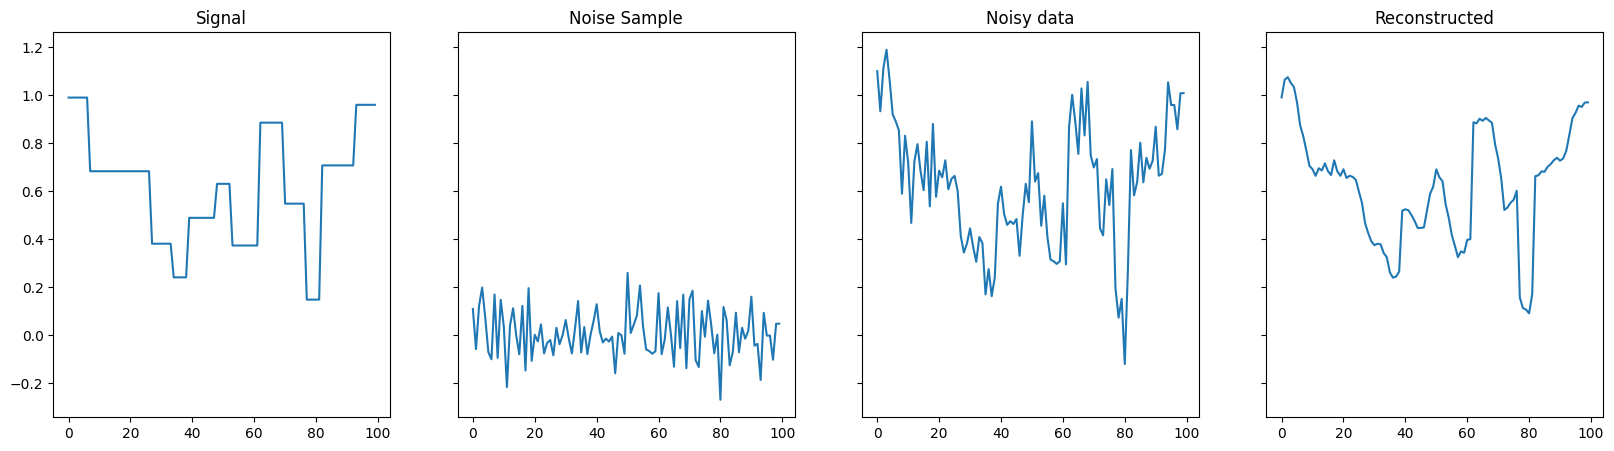

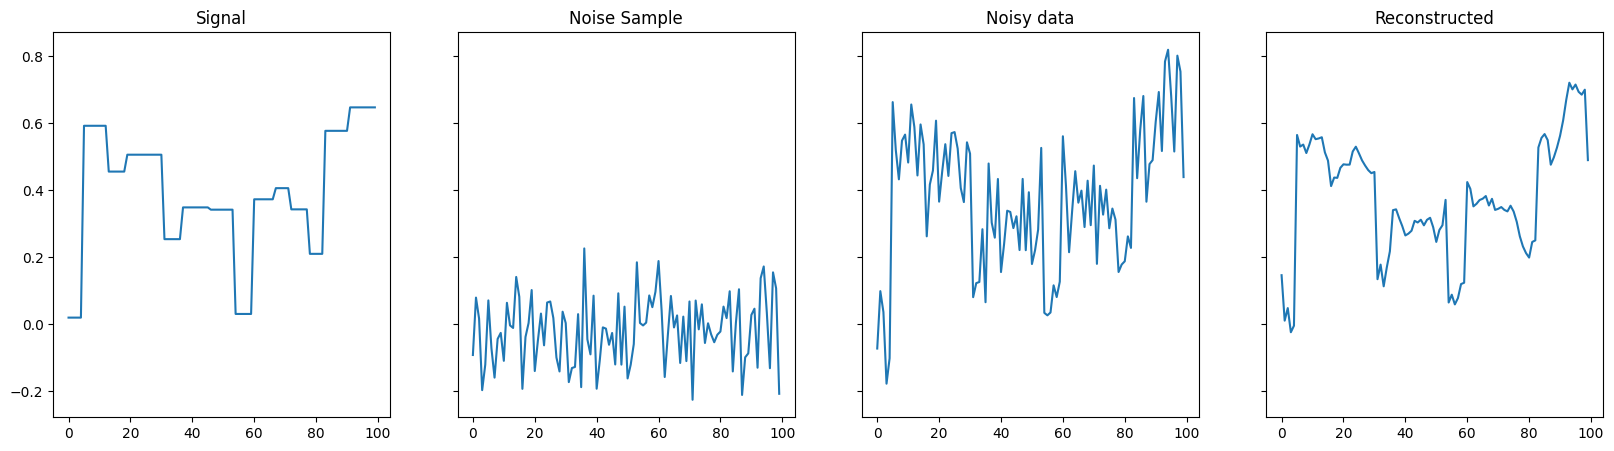

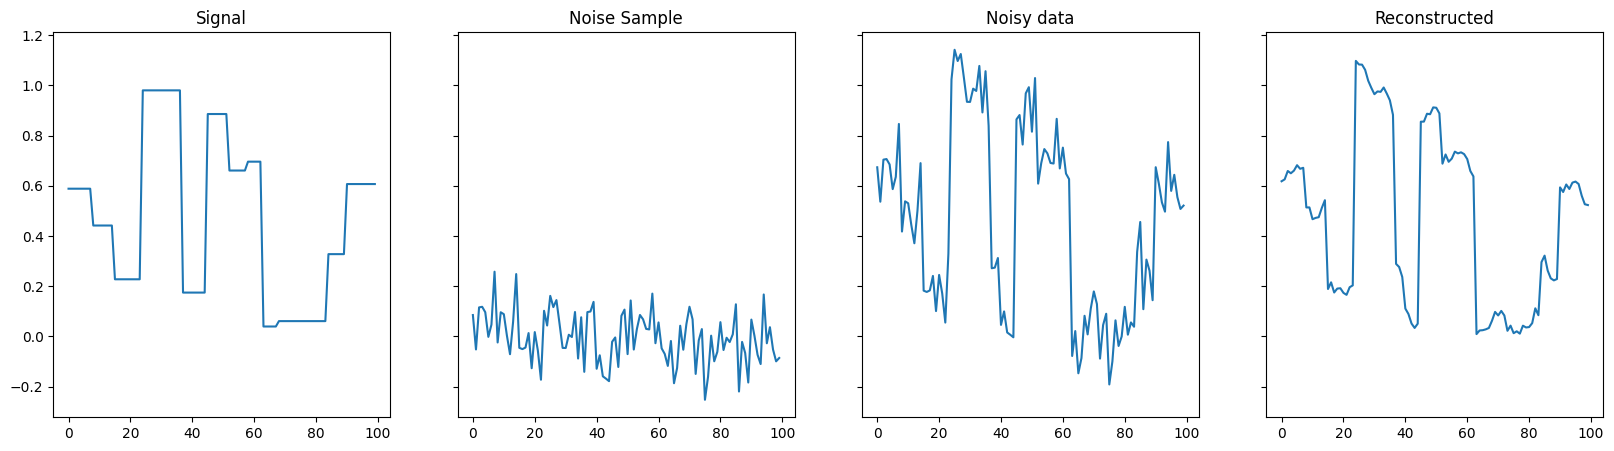

In [23]:
for i in range(10):
    visualize_denoising(val_dataset[i].unsqueeze(0), net_nn, noise_std=noise_std, figsize=(20, 5))
